In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import pyproj
from shapely.geometry import Point


In [2]:
gdf = gpd.read_file('data/WesternUSCensusTract/CensusTract2020_WesternUS.shp')

In [5]:
unique_state = gdf['STATE_FIPS'].unique()
state_list = [int(x) for x in unique_state]

In [6]:
# Print the current CRS (datum)
print("Current CRS:", gdf.crs)

# Define the target CRS (e.g., EPSG code)
target_crs = "EPSG:4326"  # WGS84

# Convert the GeoDataFrame to the target CRS
gdf_converted = gdf.to_crs(target_crs)


Current CRS: PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102003"]]


In [7]:
df = pd.read_csv("data/annual_conc_by_monitor_2023.csv")
df2 =  df.loc[df['Parameter Code'] == 88101]
df3 =  df2.loc[df['Pollutant Standard'] == 'PM25 Annual 2012']
df4 = df3.loc[df['State Code'].isin(state_list)]
df4 = df4.drop(df4[df4['State Name']== 'Texas'].index)

In [8]:
geometry = gpd.points_from_xy(df4.Longitude, df4.Latitude)
df4_gdf = gpd.GeoDataFrame(df4, geometry=geometry)

In [9]:
# Create a transformer to convert from NAD83 to WGS84
# Define the source and target coordinate reference systems (CRS)
source_crs = pyproj.CRS("EPSG:4269")  # NAD83
target_crs = pyproj.CRS("EPSG:4326")  # WGS84
transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

def convert_to_wgs84(geometry):
    lon, lat = geometry.coords.xy
    wgs84_lon, wgs84_lat = transformer.transform(lon[0], lat[0])
    return Point(wgs84_lon, wgs84_lat)

In [10]:
# Apply the transformation to rows of monitoring sites where the datum is NAD83
df4_gdf.loc[df4_gdf['Datum'] == 'NAD83', 'geometry'] = df4_gdf.loc[df4_gdf['Datum'] == 'NAD83', 'geometry'].apply(convert_to_wgs84)

In [26]:
plt.rcParams["font.family"] = "Times New Roman"

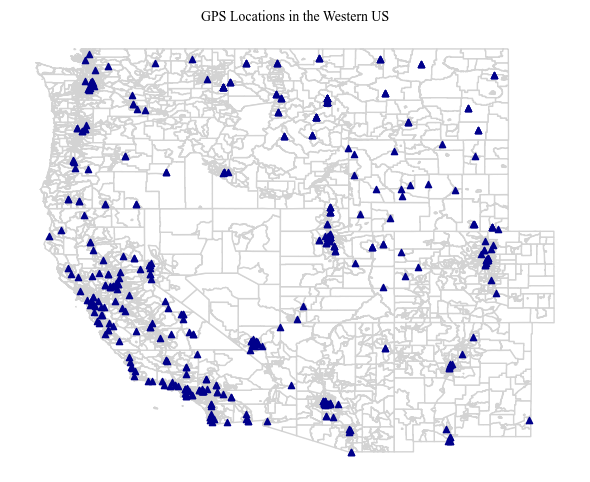

In [28]:
# Plot the state basemap
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
gdf_converted.plot(color='white', edgecolor='lightgray', ax=ax)

# Plot GPS locations on top of the state basemap
df4_gdf.plot(ax=ax, color='darkblue', marker='^', markersize=20)
ax.set_title('GPS Locations in the Western US', fontsize=10)
ax.set_axis_off()
# Set title and show the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.savefig("figures/gps_locations.png", dpi=300, bbox_inches='tight')

plt.show()
